In [1]:
#grab knapsack data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cp -r ./drive/MyDrive/knapsack-data/*.txt ./

In [3]:
"""
Use a genetic algorithm to 
solve the knapsack problem
"""
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import randn, rand
from random import randint
import operator
from copy import copy
from PIL import Image
import os
import pandas as pd

In [33]:
def read_file(filename):
    """
    Given a filename with knapsack data,
    read number,capacity,values,weights and return.
    """
    fname=filename[0:len(filename)-4].split('_')
    number=fname[0]
    capacity=fname[1]
    df = pd.read_csv(filename, delimiter=" ", names=["Value","Weight"])
    values = df['Value'].to_numpy()
    weights = df['Weight'].to_numpy()
    #drop first in values and weights column as it is number, capacity
    return int(number),int(capacity),values[1:],weights[1:]

def init_population(n,l):
    """
    initialize n candidates
    of length l
    """
    population=[list(np.random.choice([0, 1], size=(l,))) for i in range(n)]
    return population

def mutate(population, mut_rate):
    """
    Randomly mutate the candidates.
    Mutation is done by picking candidates 
    and flipping a single bit
    """
    population = np.array(population)
    mut_population=[]
    mut_count = 0
    #pick some candidates to randomly mutate
    cands = np.random.choice(range(len(population)),replace=False, size=(mut_rate,))
    #print("Mutating cands ",cands)
    for i in cands:
        #print(f"Mutating candidate {population[i]}")
        j = np.random.choice(range(len(population[0])),replace=False, size=(1,))
        #print(f"Mutating index {j}")
        if population[i][j] == 0:
            population[i][j] = 1
        else:
            population[i][j] = 0
        #print(f"Mutated candidate {population[i]}")
    return list(population)

def selection(n_remove,cap,values,weights,population):
    """
    Truncation selection.
    Given a population,
    remove the n individuals with lowest fitness.
    Invalid combinations (exceeds weight of knapsack)
    are set to fitness 0.
    """
    score = {}
    for i,candidate in enumerate(population):
        fit = fitness(cap,values,weights,candidate)
        score[f"{i}"] = fit

    #get rid of weakest individuals
    sorted_score = dict(sorted(
            score.items(),
            key=operator.itemgetter(1),
            ))

    #indexes to be eliminated
    perished_inds = list(sorted_score.keys())[0:n_remove]
    perished_inds=[int(i) for i in perished_inds]

    #remove from population perished individuals
    for i in sorted(perished_inds, reverse=True):
        del population[i]
    
    return population

def fitness(cap,values,weights,candidate):
    """
    Evaluate the fitness of a candidate
    i.e if we have 
    cap=3
    w=[1,2,3]
    v=[10,10,10]
    bs1 = [1,1,0] has f1=20 (w1=1+2=3, < cap)
    bs2 = [1,1,1] has f2=0 (w2=1+2+3=6 > cap so invalid)
    """
    total_val = np.dot(candidate, values)
    total_weight = np.dot(candidate, weights)
    if total_weight > cap:
        return 0
    else:
        return total_val

def crossover(population, rate):
    """
    randomly pick pairs of parents [p1,p2]
    perform crossover -> [c1,c2]
    add children to population
    """
    population = np.array(population)
    count = 0
    #pick some parents
    parents = np.random.choice(range(len(population)),replace=False, size=(rate*2))
    children = []
    p1_vec = parents[0:rate]
    p2_vec = parents[rate:]
    #print(f"p1 len {len(p1_vec)} p2 len {len(p2_vec)}")
    for i,p1_ind in enumerate(p1_vec):
        p2_ind = p2_vec[i]
        p1 = population[p1_ind]
        p2 = population[p2_ind]
        p1_temp = copy(p1)
        #print(f"p1: {p1} p2: {p2}")
        """
        perform crossover (a and b are sublists)
        p1 = [a1, a2], p2 = [b1, b2]
        -> c1 = [a1, b2], c2 = [b1, a2]
        OR 
        -> c1 = [b1, a2], c2 = [a1, b2]
        """
        l = len(p1)
        half = int(l/2)
        rnd = np.random.choice([0,1],size=1)
        if rnd==0:
            #print("swapping first half.")
            #swap first half of bitstring
            p1[0:half] = p2[0:half]
            p2[0:half] = p1_temp[0:half]
        else:
            #print("swapping second half.")
            #swap second half of bitstring
            p1[half:] = p2[half:]
            p2[half:] = p1_temp[half:]
        #print(f"c1: {p1} c2: {p2}")
        #add children to population
        population=list(population)
        children.append(p1)
        children.append(p2)
    result = population + list(children)
    return result

Solving 10_269.txt knapsack problem
Number of items: 10
 Capacity: 269
Object values: [55 10 47  5  4 50  8 61 85 87]
 Object weights: [95  4 60 32 23 72 80 62 65 46]


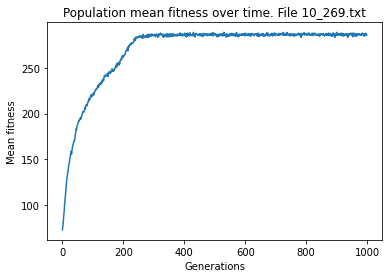

Best fitness: 295
 Solution: [0 1 1 1 0 0 0 1 1 1]
Solving 23_10000.txt knapsack problem
Number of items: 23
 Capacity: 10000
Object values: [981 980 979 978 977 976 487 974 970 485 485 970 970 484 484 976 974 482
 962 961 959 958 857]
 Object weights: [983 982 981 980 979 978 488 976 972 486 486 972 972 485 485 969 966 483
 964 963 961 958 959]


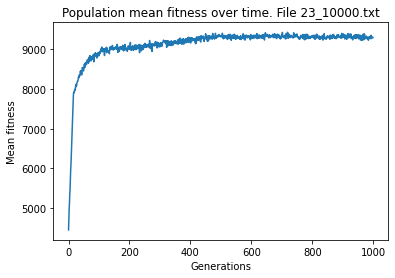

Best fitness: 9753
 Solution: [1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0]


In [55]:
# getting a weird result for 100_995.txt because all the objects have high weights 
# and the ideal solution is sparse
for filename in ["10_269.txt", "23_10000.txt"]:
    bs_len,cap,values,weights = read_file(filename)
    print(f"Solving {filename} knapsack problem")
    print(f"Number of items: {bs_len}\n Capacity: {cap}")
    print(f"Object values: {values}\n Object weights: {weights}")

    pop_num = 1000
    #control rate of births + deaths
    size_rate = 50
    #control rate of mutation
    mut_rate = 50
    #initialise pop_num individuals of length bs_len
    population = init_population(pop_num, bs_len)
    fit_arr = []
    for i in range(1000):
        fits = [fitness(cap,values,weights,candidate) for candidate in population]
        #print best solution
        best = np.argmax(fits)
        population = selection(size_rate,cap,values,weights,population)
        population = mutate(population, mut_rate)
        population = crossover(population,int(size_rate/2))
        fit_arr.append(np.mean(fits))
    plt.plot(fit_arr)
    plt.xlabel("Generations")
    plt.ylabel("Mean fitness")
    plt.title(f"Population mean fitness over time. File {filename}")
    plt.show()
    print(f"Best fitness: {fits[best]}\n Solution: {population[best]}")